
## Clean Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_season(date_str):
    """Determines the season based on the given date string (MM-DD-YYYY)."""
    try:
        date_obj = pd.to_datetime(date_str, format='%m-%d-%Y', errors='coerce')
        month = date_obj.month
        day = date_obj.day

        if (month == 12 and day >= 21) or month in [1, 2] or (month == 3 and day <= 19):
            return "winter"
        elif (month == 3 and day >= 20) or month in [4, 5]:
            return "spring"
        elif (month == 6 and day >= 21) or month in [7, 8]:
            return "summer"
        else:
            return "fall"
    except (ValueError, AttributeError) as e:
        print(f"Error determining season for date '{date_str}': {e}")
        return None


def get_time_of_day(time_str):
    """Categorizes time into Morning, Afternoon, Evening, or Night, handling various formats."""
    try:
        time_str = time_str.strip()
        time_obj = pd.to_datetime(time_str, format='%H:%M:%S', errors='coerce')
        if pd.isna(time_obj):
            return None
        hour = time_obj.hour
        if 5 <= hour < 12:
            return "morning"
        elif 12 <= hour < 17:
            return "afternoon"
        elif 17 <= hour < 21:
            return "evening"
        else:
            return "night"
    except (ValueError, AttributeError) as e:
        print(f"Error determining time of day for time '{time_str}': {e}")
        return None

def get_weekday(date_str):
    """Gets the weekday (Monday-Sunday) from a date string (MM-DD-YYYY)."""
    try:
        date_obj = pd.to_datetime(date_str, format='%m-%d-%Y')
        return date_obj.strftime('%A')
    except ValueError:
        return "Invalid Date"


def process_crime_data(file_path, city_name):
    """Processes crime data, handling different cities and crime column names."""
    try:
        df = pd.read_csv(file_path, low_memory=False)
        df = df.dropna(how='all', axis=1)
        df = df.dropna()
        df['city'] = city_name

        time_column = next((col for col in ['Occurrence_Date_PT', 'incident_occurred_at'] if col in df.columns), None)
        if time_column is None:
            print("Error: Could not find date/time column.")
            return None

        try:
            df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
        except Exception as e:
            print(f"Error converting '{time_column}' to datetime: {e}. Check column data types.")
            return None

        df['date'] = df[time_column].dt.strftime('%m-%d-%Y')
        df['time'] = df[time_column].dt.strftime('%H:%M:%S')

        # Clean the Time column
        df['time'] = df['time'].str.strip()
        df['time'] = df['time'].str.replace(r'[^\d:]', '', regex=True)
        df['time'] = df['time'].str[:8]

        df['season'] = df['date'].apply(get_season)
        df['time_of_day'] = df['time'].apply(get_time_of_day)
        df['day_of_week'] = df['date'].apply(get_weekday)
        df = df.drop(columns=[time_column])

        crime_col = 'offense_category' if city_name == 'Detroit' else 'Offense_Category'
        if crime_col not in df.columns:
            print(f"Error: Crime column '{crime_col}' not found for {city_name}.")
            return None

        df['crime_type'] = df[crime_col].str.lower()

        # Apply crime type mapping and filter
        valid_crimes = ['assault', 'robbery', 'gta']
        if city_name == 'Sacramento' or city_name == 'Detroit':
            df['crime_type'] = df['crime_type'].replace({
                'assault': 'assault',
                'aggravated assault': 'assault',
                'simple assault': 'assault',
                'domestic violence assault': 'assault',
                'robbery': 'robbery',
                'stolen vehicle': 'gta'
            })
            df = df[df['crime_type'].isin(valid_crimes)]


        df = df[['city', 'date', 'time', 'season', 'time_of_day', 'day_of_week', 'crime_type']]

        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: CSV file is empty at {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage
sacramento_df = process_crime_data('Sacramento_Crime.csv', 'Sacramento')
detroit_df = process_crime_data('Detroit_Crime.csv', 'Detroit')

if sacramento_df is not None:
    sacramento_df.to_csv('c_sacramento.csv', index=False)
    print("Sacramento data processed and saved.")

if detroit_df is not None:
    detroit_df.to_csv('c_detroit.csv', index=False)
    print("Detroit data processed and saved.")


Error: File not found at Sacramento_Crime.csv
Error: File not found at Detroit_Crime.csv


In [2]:
print(sacramento_df.dtypes)
print(detroit_df.dtypes)

AttributeError: 'NoneType' object has no attribute 'dtypes'

In [ ]:
print(sacramento_df['crime_type'].unique())
print(detroit_df['crime_type'].unique())

In [ ]:
print(sacramento_df[['time_of_day', 'season', 'day_of_week']].nunique())
print(sacramento_df[['time_of_day', 'season', 'day_of_week']].apply(pd.Series.nunique))
print(detroit_df[['time_of_day', 'season', 'day_of_week']].nunique())
print(detroit_df[['time_of_day', 'season', 'day_of_week']].apply(pd.Series.nunique))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_naive_bayes(df, num_runs=20):
    """Evaluates Naive Bayes with improved data handling."""
    X = df[['time_of_day', 'season', 'day_of_week']]
    y = df['crime_type']

    results = {}
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

        models = {
            "CategoricalNB": CategoricalNB(),
            "GaussianNB": GaussianNB(),
        }

        for name, model in models.items():
            try:
                if name == "CategoricalNB":
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                elif name == "GaussianNB":
                    from sklearn.preprocessing import OrdinalEncoder
                    enc = OrdinalEncoder()
                    X_train_ord = enc.fit_transform(X_train)
                    X_test_ord = enc.transform(X_test)
                    model.fit(X_train_ord, y_train)
                    y_pred = model.predict(X_test_ord)

                results.setdefault(name, {}).setdefault('accuracy', []).append(accuracy_score(y_test, y_pred))
                results[name].setdefault('precision', []).append(precision_score(y_test, y_pred, average='weighted'))
                results[name].setdefault('recall', []).append(recall_score(y_test, y_pred, average='weighted'))
                results[name].setdefault('f1', []).append(f1_score(y_test, y_pred, average='weighted'))
            except (ValueError, TypeError) as e:
                print(f"Error training {name}: {e}")

    # Calculate averages
    for model_name, metrics in results.items():
        for metric, scores in metrics.items():
            results[model_name][metric] = np.mean(scores) if scores else 0

    return results


def generate_summary_tables_and_charts(results_dict):
    """Generates summary tables and charts."""
    results_df = pd.DataFrame(results_dict).T.reset_index()
    results_df = results_df.rename(columns={'index': 'Metric'})

    print("\nSummary Table:")
    print(results_df)

    # Reshape for better plotting
    melted_df = results_df.melt(id_vars=['Metric'], var_name='Model', value_name='Score')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=melted_df)
    plt.title('Comparison of Naive Bayes Performance (Average Across 20 Runs)')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


# Load the cleaned datasets
sacramento_df = pd.read_csv('c_sacramento.csv')
detroit_df = pd.read_csv('c_detroit.csv')
atlanta_df = pd.read_csv('c_atlanta.csv')
baltimore_df = pd.read_csv('c_baltimore.csv')
boston_df = pd.read_csv('c_boston.csv')
cleveland_df = pd.read_csv('c_cleveland.csv')
kansascity_df = pd.read_csv('c_kansascity.csv')
louisville_df = pd.read_csv('c_louisville.csv')
memphis_df = pd.read_csv('c_memphis.csv')
tucson_df = pd.read_csv('c_tucson.csv')

#Evaluate models
sacramento_results = evaluate_naive_bayes(sacramento_df)
detroit_results = evaluate_naive_bayes(detroit_df)
atlanta_results = evaluate_naive_bayes(atlanta_df)
baltimore_results = evaluate_naive_bayes(baltimore_df)
boston_results = evaluate_naive_bayes(boston_df)
cleveland_results = evaluate_naive_bayes(cleveland_df)
kansascity_results = evaluate_naive_bayes(kansascity_df)
louisville_results = evaluate_naive_bayes(louisville_df)
memphis_results = evaluate_naive_bayes(memphis_df)
tucson_results = evaluate_naive_bayes(tucson_df)

print("Sacramento Crime Data Results:")
generate_summary_tables_and_charts(sacramento_results)
print("\nDetroit Crime Data Results:")
generate_summary_tables_and_charts(detroit_results)
print("\nAtlanta Crime Data Results:")
generate_summary_tables_and_charts(atlanta_results)
print("\nBaltimore Crime Data Results:")
generate_summary_tables_and_charts(baltimore_results)
print("\nBoston Crime Data Results:")
generate_summary_tables_and_charts(boston_results)
print("\nCleveland Crime Data Results:")
generate_summary_tables_and_charts(cleveland_results)
print("\nKansas City Crime Data Results:")
generate_summary_tables_and_charts(kansascity_results)
print("\nLouisville Crime Data Results:")
generate_summary_tables_and_charts(louisville_results)
print("\nMemphis Crime Data Results:")
generate_summary_tables_and_charts(memphis_results)
print("\nTucson Crime Data Results:")
generate_summary_tables_and_charts(tucson_results)



## Naive Bayes

Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 0: invalid literal for int() with base 10: '8:08'
Error training CategoricalNB in run 1: invalid literal for int() with base 10: '11:56'
Error training CategoricalNB in run 2: invalid literal for int() with base 10: '15:22'
Error training CategoricalNB in run 3: invalid literal for int() with base 10: '14:24'
Error training CategoricalNB in run 4: invalid literal for int() with base 10: '3:47'
Error training CategoricalNB in run 5: invalid literal for int() with base 10: '19:10'
Error training CategoricalNB in run 6: invalid literal for int() with base 10: '11:12'
Error training CategoricalNB in run 7: invalid literal for int() with base 10: '21:30'
Error training CategoricalNB in run 8: invalid literal for int() with base 10: '3:30'
Error training CategoricalNB in run 9: invalid literal for int() with base 10: '16:19'
Error training CategoricalNB in run 10: invalid literal for int() with base 10: '20:33'
Error training CategoricalNB in run 11: inval

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'night'
Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'morning'
Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'afternoon'
Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'evening'
Error training CategoricalNB in run 0: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 1: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 2: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 3: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 4: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 5: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 6: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 7: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 8: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 9: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 10: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 11: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 12: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 13: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 14: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 15: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 16: invalid literal for int() with base 10: 'evening'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 17: invalid literal for int() with base 10: 'afternoon'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 18: invalid literal for int() with base 10: 'morning'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Error training CategoricalNB in run 19: invalid literal for int() with base 10: 'night'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Summary Table:
       Metric  accuracy  precision    recall        f1       auc        city
0  GaussianNB  0.620836   0.385482  0.620836  0.475624  0.556868  Sacramento
1  GaussianNB  0.714445   0.510433  0.714445  0.595449  0.558035     Detroit
2  GaussianNB  0.501236   0.399230  0.501236  0.425251  0.566091     Atlanta
3  GaussianNB  0.607315   0.368834  0.607315  0.458942  0.520201   Baltimore
4  GaussianNB  0.696278   0.484891  0.696278  0.571645  0.510393      Boston
5  GaussianNB  0.778489   0.606048  0.778489  0.681529  0.532737   Cleveland
6  GaussianNB  0.382127   0.380537  0.382127  0.380081  0.563348  KansasCity
7  GaussianNB  0.739499   0.546869  0.739499  0.628758  0.525003  Louisville
8  GaussianNB  0.789644   0.623559  0.789644  0.696836  0.593119     Memphis
9  GaussianNB  0.439676   0.345401  0.439676  0.282479  0.530341      Tucson


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a grad

<Figure size 1500x800 with 0 Axes>

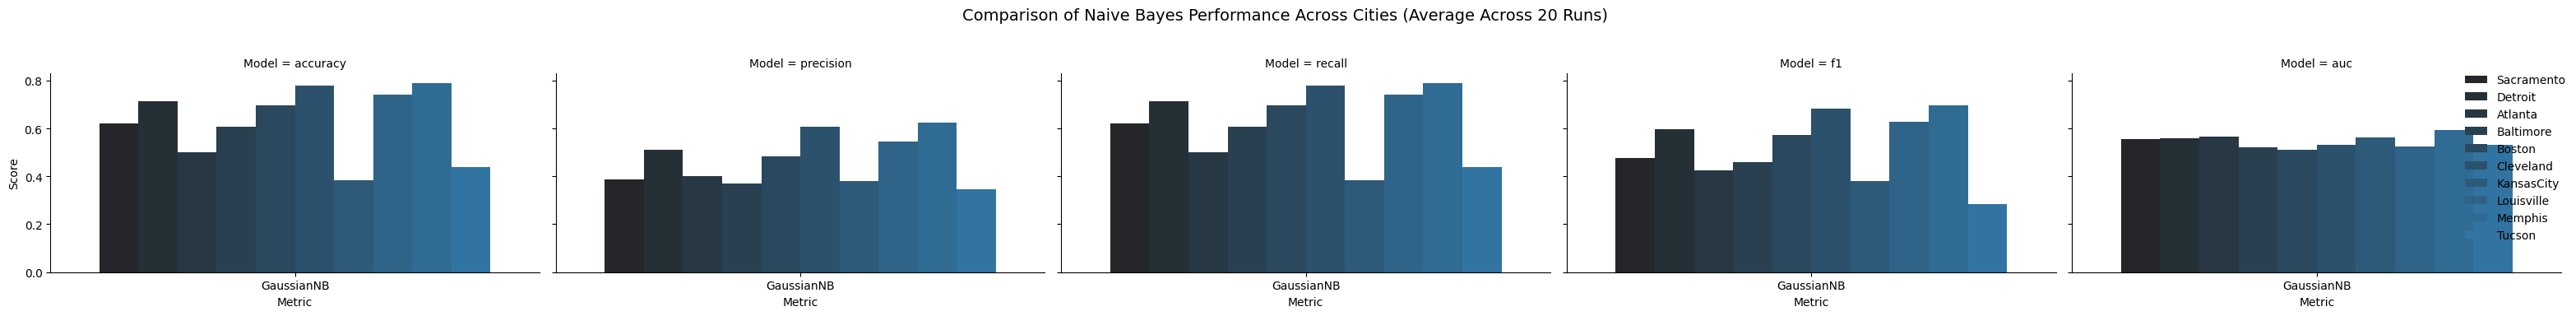

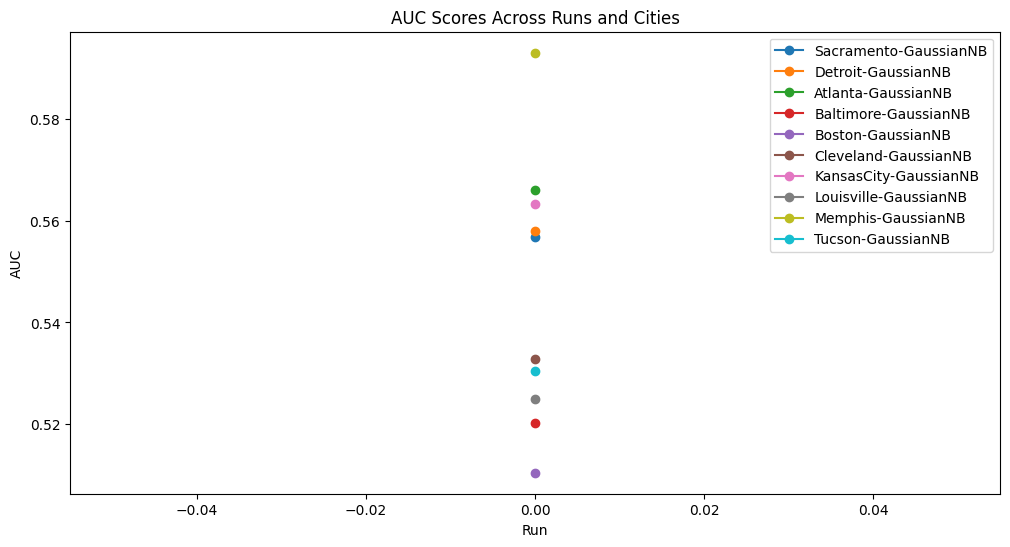

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OrdinalEncoder

def evaluate_naive_bayes(df, num_runs=20):
    """Evaluates Naive Bayes, including AUC, with improved error handling."""
    X = df[['time_of_day', 'season', 'day_of_week']]
    y = df['crime_type']

    # Input validation
    required_cols = ['time_of_day', 'season', 'day_of_week', 'crime_type']
    missing_cols = set(required_cols) - set(df.columns)

    results = {}
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

        models = {
            "CategoricalNB": CategoricalNB(),
            "GaussianNB": GaussianNB(),
        }

        for name, model in models.items():
            try:
                if name == "CategoricalNB":
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_prob = model.predict_proba(X_test)
                elif name == "GaussianNB":
                    enc = OrdinalEncoder()
                    X_train_ord = enc.fit_transform(X_train)
                    X_test_ord = enc.transform(X_test)
                    model.fit(X_train_ord, y_train)
                    y_pred = model.predict(X_test_ord)
                    y_prob = model.predict_proba(X_test_ord)

                results.setdefault(name, {}).setdefault('accuracy', []).append(accuracy_score(y_test, y_pred))
                results[name].setdefault('precision', []).append(precision_score(y_test, y_pred, average='weighted'))
                results[name].setdefault('recall', []).append(recall_score(y_test, y_pred, average='weighted'))
                results[name].setdefault('f1', []).append(f1_score(y_test, y_pred, average='weighted'))

                #Robust AUC calculation
                le = LabelEncoder()
                y_test_encoded = le.fit_transform(y_test)
                try:
                    auc = roc_auc_score(y_test_encoded, y_prob, multi_class='ovr')
                    results[name].setdefault('auc', []).append(auc)
                except ValueError as e:
                    print(f"Error calculating AUC for {name} in run {i}: {e}")
                    results[name].setdefault('auc', []).append(np.nan) #Use NaN instead of 0

            except (ValueError, TypeError) as e:
                print(f"Error training {name} in run {i}: {e}")

    #Calculate averages, handling NaN values
    for model_name, metrics in results.items():
        for metric, scores in metrics.items():
            results[model_name][metric] = np.nanmean(scores) if scores else 0

    return results

def generate_summary_tables_and_charts(all_results):
    """Generates summary tables and charts for multiple cities."""
    all_results_df = pd.DataFrame()
    for city, results in all_results.items():
        temp_df = pd.DataFrame(results).T.reset_index()
        temp_df['city'] = city
        all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)

    all_results_df = all_results_df.rename(columns={'index': 'Metric'})

    print("\nSummary Table:")
    print(all_results_df)

    # Reshape for better plotting
    melted_df = all_results_df.melt(id_vars=['Metric', 'city'], var_name='Model', value_name='Score')

    plt.figure(figsize=(15, 8))
    g = sns.FacetGrid(melted_df, col="Model", height=4, aspect=1.5) #Use FacetGrid for subplots
    g.map(sns.barplot, "Metric", "Score", "city")
    g.add_legend()
    plt.suptitle('Comparison of Naive Bayes Performance Across Cities (Average Across 20 Runs)', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # AUC plot
    plt.figure(figsize=(12, 6))
    for city, results in all_results.items():
        for model, metrics in results.items():
            auc_scores = metrics['auc']
            if isinstance(auc_scores, (list, np.ndarray)): #Check if auc_scores is iterable
                if not all(np.isnan(x) for x in auc_scores):
                    plt.plot(range(len(auc_scores)), auc_scores, label=f'{city}-{model}')
            elif not np.isnan(auc_scores): #Handle case where auc_scores is a single float
                plt.plot(0, auc_scores, marker='o', label=f'{city}-{model}') #Plot a single point

    plt.xlabel('Run')
    plt.ylabel('AUC')
    plt.title('AUC Scores Across Runs and Cities')
    plt.legend()
    plt.show()


# Load all datasets
city_dfs = {
    'Sacramento': pd.read_csv('c_sacramento.csv'),
    'Detroit': pd.read_csv('c_detroit.csv'),
    'Atlanta': pd.read_csv('c_atlanta.csv'),
    'Baltimore': pd.read_csv('c_baltimore.csv'),
    'Boston': pd.read_csv('c_boston.csv'),
    'Cleveland': pd.read_csv('c_cleveland.csv'),
    'KansasCity': pd.read_csv('c_kansascity.csv'),
    'Louisville': pd.read_csv('c_louisville.csv'),
    'Memphis': pd.read_csv('c_memphis.csv'),
    'Tucson': pd.read_csv('c_tucson.csv')
}

all_results = {}
for city, df in city_dfs.items():
    results = evaluate_naive_bayes(df)
    all_results[city] = results

generate_summary_tables_and_charts(all_results)

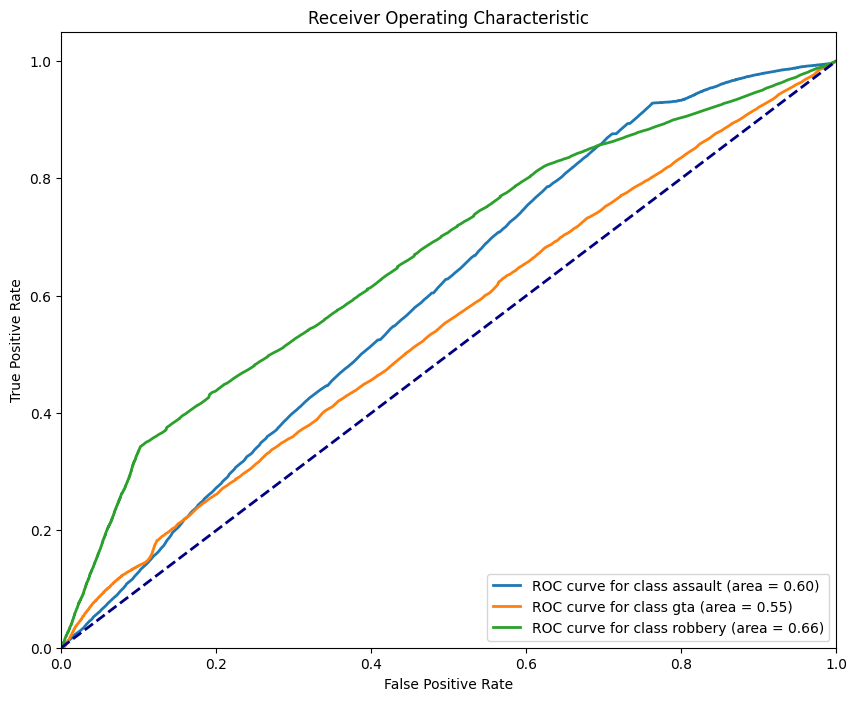

Macro-averaged AUC: 0.6027195264275472


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Data Loading and Preprocessing ---

# Load your data (replace with your actual file paths)
cities = {
    'Sacramento': pd.read_csv('c_sacramento.csv'),
    'Detroit': pd.read_csv('c_detroit.csv'),
    'Atlanta': pd.read_csv('c_atlanta.csv'),
    'Baltimore': pd.read_csv('c_baltimore.csv'),
    'Boston': pd.read_csv('c_boston.csv'),
    'Cleveland': pd.read_csv('c_cleveland.csv'),
    'KansasCity': pd.read_csv('c_kansascity.csv'),
    'Louisville': pd.read_csv('c_louisville.csv'),
    'Memphis': pd.read_csv('c_memphis.csv'),
    'Tucson': pd.read_csv('c_tucson.csv')
}

# Combine data from all cities
df = pd.concat(cities.values())

# Label Encoding for categorical features
le = LabelEncoder()
for col in ['day_of_week', 'season', 'time_of_day', 'crime_type']:
    df[col] = le.fit_transform(df[col])

# Define features (X) and target (y)
X = df[['time_of_day', 'season', 'day_of_week']]
y = df['crime_type'] #Predicting any crime

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- 2. Model Training and Prediction ---

# Use OneVsRestClassifier for multi-class ROC curves
model = OneVsRestClassifier(GaussianNB())
model.fit(X_train, y_train)

# Predict probabilities for each class
y_prob = model.predict_proba(X_test)

# Calculate ROC curves and AUC for each class
n_classes = len(le.classes_) #Get number of classes from LabelEncoder
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, i], pos_label=i)  #pos_label specifies which class is positive
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {le.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate Macro-averaged AUC - specifying multi_class parameter
macro_auc = roc_auc_score(y_test, y_prob, average='macro', multi_class='ovr') #Use 'ovr' or 'ovo'
print(f"Macro-averaged AUC: {macro_auc}")

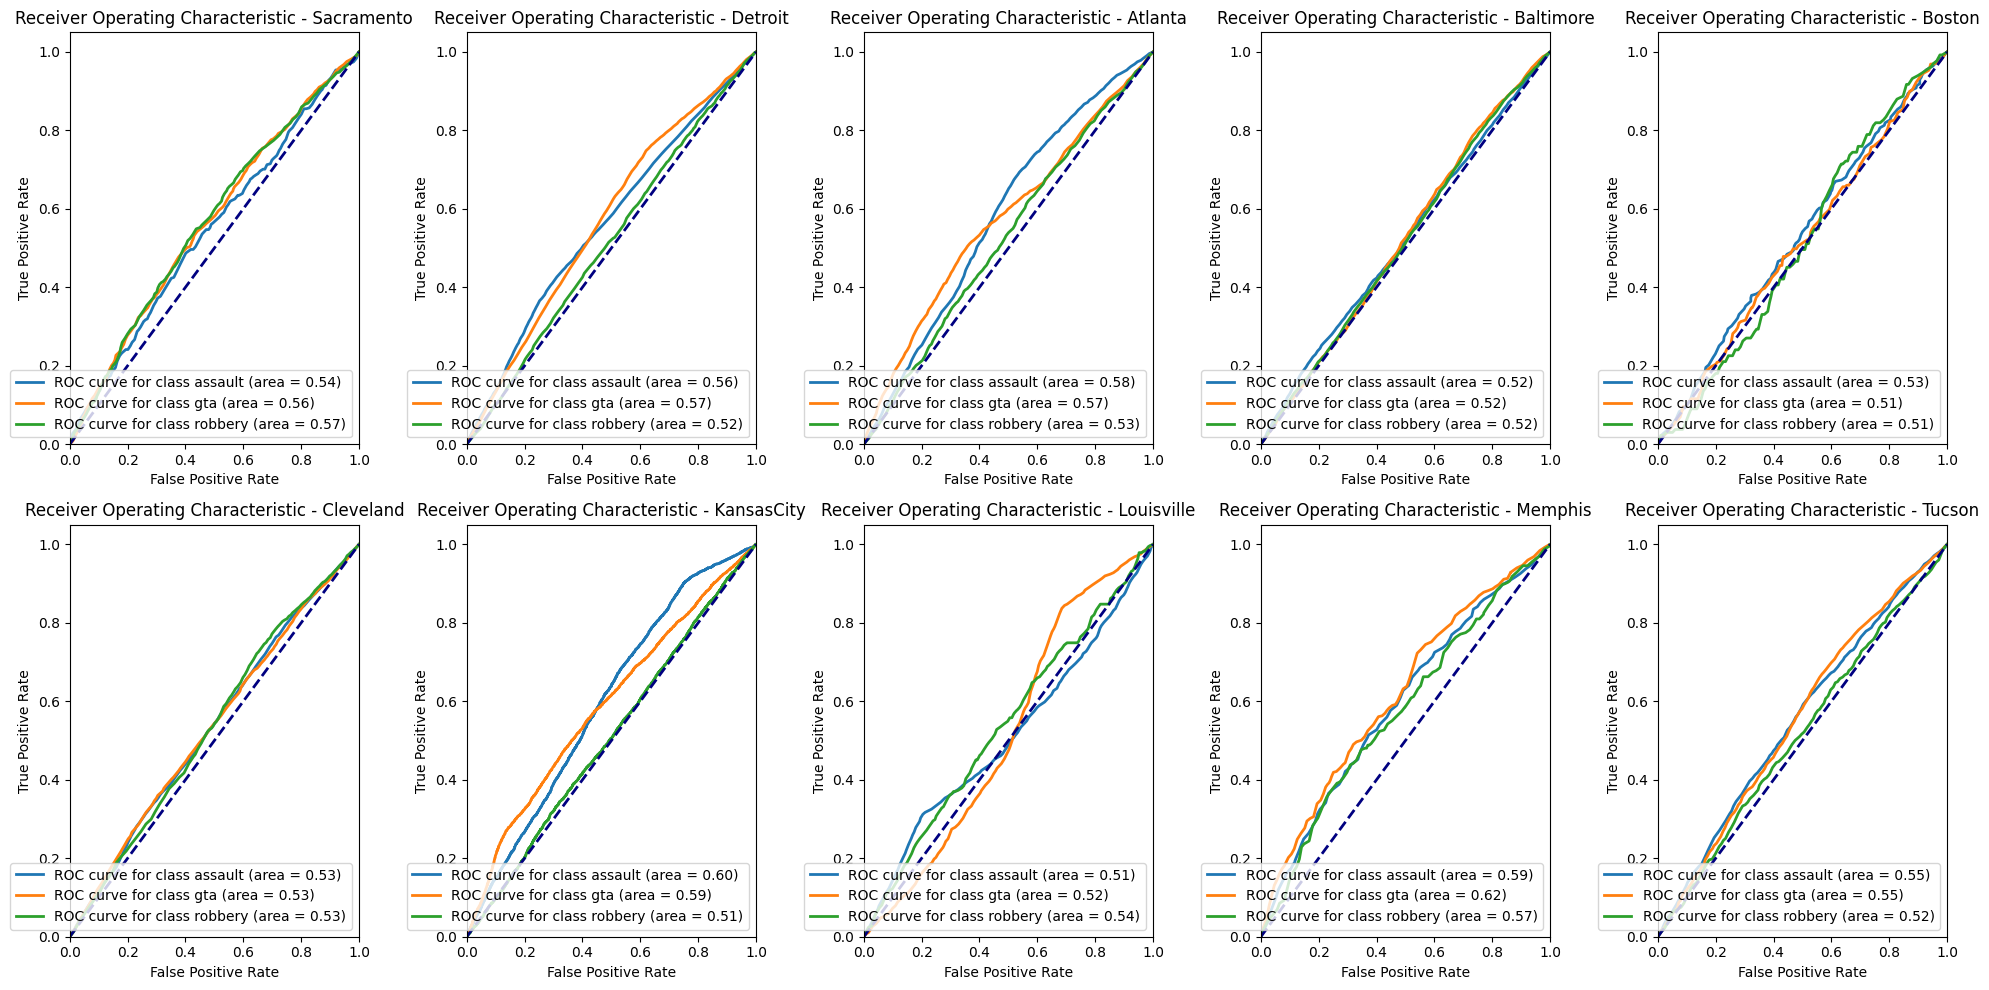

Macro-averaged AUC for Sacramento: 0.6027195264275472
Macro-averaged AUC for Detroit: 0.6027195264275472
Macro-averaged AUC for Atlanta: 0.6027195264275472
Macro-averaged AUC for Baltimore: 0.6027195264275472
Macro-averaged AUC for Boston: 0.6027195264275472
Macro-averaged AUC for Cleveland: 0.6027195264275472
Macro-averaged AUC for KansasCity: 0.6027195264275472
Macro-averaged AUC for Louisville: 0.6027195264275472
Macro-averaged AUC for Memphis: 0.6027195264275472
Macro-averaged AUC for Tucson: 0.6027195264275472


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Data Loading ---
cities = {
    'Sacramento': pd.read_csv('c_sacramento.csv'),
    'Detroit': pd.read_csv('c_detroit.csv'),
    'Atlanta': pd.read_csv('c_atlanta.csv'),
    'Baltimore': pd.read_csv('c_baltimore.csv'),
    'Boston': pd.read_csv('c_boston.csv'),
    'Cleveland': pd.read_csv('c_cleveland.csv'),
    'KansasCity': pd.read_csv('c_kansascity.csv'),
    'Louisville': pd.read_csv('c_louisville.csv'),
    'Memphis': pd.read_csv('c_memphis.csv'),
    'Tucson': pd.read_csv('c_tucson.csv')
}


# --- 2. Preprocessing and Modeling Function ---
def process_city(city_df, city_name, ax):
    """Processes data for a single city, trains a model, and generates ROC curves on a given axes."""
    le = LabelEncoder()
    for col in ['day_of_week', 'season', 'time_of_day', 'crime_type']:
        city_df[col] = le.fit_transform(city_df[col])

    X = city_df[['time_of_day', 'season', 'day_of_week']]
    y = city_df['crime_type']
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = OneVsRestClassifier(GaussianNB())
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)

    n_classes = len(le.classes_)
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'ROC curve for class {le.classes_[i]} (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic - {city_name}')
    ax.legend(loc="lower right")


# --- 3. Create Subplots and Process Cities ---
fig, axes = plt.subplots(2, 5, figsize=(20, 10)) # 2 rows, 5 columns
axes = axes.flatten() #Flatten the axes array for easier iteration

city_names = list(cities.keys())
for i, city_name in enumerate(city_names):
    process_city(cities[city_name].copy(), city_name, axes[i])

# Remove any extra subplots if there are fewer than 10 cities
for i in range(len(city_names), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout() #Adjust spacing between subplots
plt.show()

#Calculate Macro-averaged AUC for each city
for city_name, city_df in cities.items():
    # ... (same preprocessing as in process_city function) ...
    macro_auc = roc_auc_score(y_test, y_prob, average='macro', multi_class='ovr')
    print(f"Macro-averaged AUC for {city_name}: {macro_auc}")

